# NEU-Regressors

---
## Outline of NEU:

---

Get Training and Validation Sets: $\{x_n\}_{n\leq N} \to \{x_{n,t}\}_{n\leq N_1}, \{x_{n,v}\}_{n\leq N_2}$

1. Learn Feature Map:
 For $i\leq \#$ of segment do:
  - Train new feature map segment: $ \hat{\phi} \in \operatorname{argmin}_{\phi \in \operatorname{NN}_{\star:d;J} }
   \sum_{n\leq N} w_n^{\star,\lambda}\,
   L\left(f(x_n),A\phi\circ \hat{\phi}_i(x_n)+b,x_n\right) + P(A\phi\circ \hat{\phi}_i+b)$,
  - Update feature map: $\phi_{i+1} = \hat{\phi}\circ \hat{\phi}_i$,
  - Learn on Affine Model on partial training data: with current feature map: $\hat{A}_i,\hat{b}_i \in \operatorname{argmin}_{A,b}
   \sum_{n\leq N} w_n^{\star,\lambda}\,
   L\left(f(x_n),A\hat{\phi}_i(x_n)+b,x_n\right) + P(A\hat{\phi}_i+b)$, 
2. Cross-Validate Feature Map Depth:  
  - Pick Depth $\hat{I}$ with best validation-error
  
3. Get full Model with NEU-Feature Map:

  - $ \hat{f}^{NEU} \in \operatorname{argmin}_{\hat{f} \in \mathcal{F}}
   \sum_{n\leq N} w_n^{\star,\lambda}\,
   L\left(f(x_n),\hat{f}\circ \hat{\phi}_{\hat{I}}(x_n)+b,x_n\right) + P(\hat{f}\circ \hat{\phi}_{\hat{I}})$.
   
**Return:** $\hat{f}^{NEU}$.

---
---
---

# What this script does?
- Train NEU using different common regression models
- Evaluate against benchmarks


All this is done on synthetic data generated from the following types of functions:

### Functions from the paper:
 - 1) $\min\{\exp(\frac{-1}{(1+x)^2}),x+\cos(x)\}$. Reason: Evaluate performance for pasted functions and general badness.
 - 2) $\cos(\exp(-x))$.  Reason: Evaluate performance for non-periodic osculations.
 - 3) $I_{(-\infty,\frac1{2})}$.  Reason: Evaluation performance on a single jump.  
 - 4) Fractional Brownian Motion Realization
 
 ---

# Generate Training Data

In [57]:
# First Round Initializations (Global Level) #
#============================================#
# Load Dependances and makes path(s)
exec(open('Initializations_Dump.py').read())
# Load Hyper( and meta) parameter(s)
exec(open('HyperParameter_Grid.py').read())
# %run Helper_Functions.ipynb
exec(open('Helper_Functions.py').read())
# Load Models
# %run Architecture_Builder.ipynb
exec(open('Architecture_Builder.py').read())

Parameter Grids Build and Loaded!
Complete NEU-Structure Building Procedure!!!
Complete NEU-Structure Building Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Deep Feature Builder - Ready
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN (Fully Coupled) Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!


### Fix Seeds for Reproducability

In [58]:
# Numpy
np.random.seed(2020)
# Tensorflow
tf.random.set_seed(2020)
# Python's Seed
random.seed(2020)

When generating data...you may use one of the following options:
- For evaluating non-localy patterns: **"nonlocality"**
- For evaluating model performance when faced with non-stationary osculatory behaviour: **"oscilatory"**
- For evaluating jump-type performance when faced with a discontinuity: **"jumpdiscontinuity"**
- For pattern which looks like noise/highly fractal-like/low Hölder regularity: **"rough"**
- For fun/debugging/sanity checking: **"the_nightmare"**

#================================================#
 Training Datasize: 449 and test datasize: 150.  
#================================================#


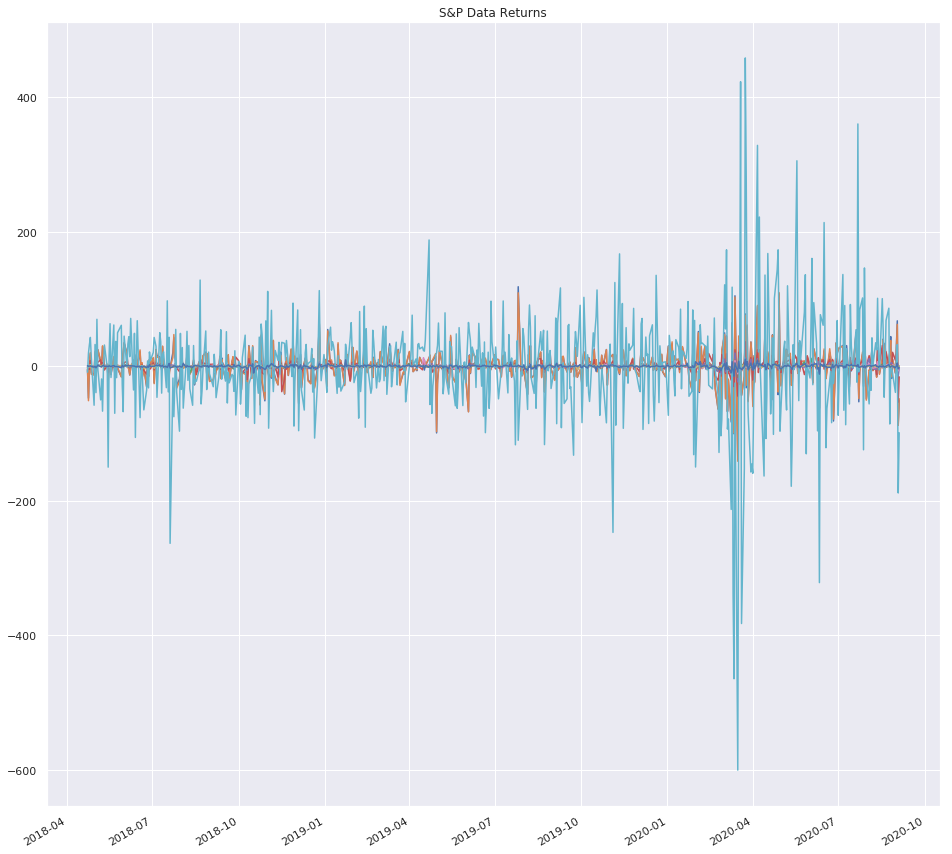

In [3]:
#------------------------#
# Run External Notebooks #
#------------------------#
if Option_Function == "SnP":
    #--------------#
    # Get S&P Data #
    #--------------#
    #=# SnP Constituents #=#
    # Load Data
    snp_data = pd.read_csv('inputs/data/snp500_data/snp500-adjusted-close.csv')
    # Format Data
    ## Index by Time
    snp_data['date'] = pd.to_datetime(snp_data['date'],infer_datetime_format=True)
    #-------------------------------------------------------------------------------#

    #=# SnP Index #=#
    ## Read Regression Target
    snp_index_target_data = pd.read_csv('inputs/data/snp500_data/GSPC.csv')
    ## Get (Reference) Dates
    dates_temp = pd.to_datetime(snp_data['date'],infer_datetime_format=True).tail(600)
    ## Format Target
    snp_index_target_data = pd.DataFrame({'SnP_Index': snp_index_target_data['Close'],'date':dates_temp.reset_index(drop=True)})
    snp_index_target_data['date'] = pd.to_datetime(snp_index_target_data['date'],infer_datetime_format=True)
    snp_index_target_data.set_index('date', drop=True, inplace=True)
    snp_index_target_data.index.names = [None]
    #-------------------------------------------------------------------------------#
    
    ## Get Rid of Rubbish
    snp_data.set_index('date', drop=True, inplace=True)
    snp_data.index.names = [None]
    ## Get Rid of NAs and Expired Trends
    snp_data = (snp_data.tail(600)).dropna(axis=1).fillna(0)
    
    # Apple
    snp_index_target_data = snp_data[{'AAPL'}]
    snp_data = snp_data[{'IBM','QCOM','MSFT','CSCO','ADI','MU','MCHP','NVR','NVDA','GOOGL','GOOG'}]
    # Get Return(s)
    snp_data_returns = snp_data.diff().iloc[1:]
    snp_index_target_data_returns = snp_index_target_data.diff().iloc[1:]
    #--------------------------------------------------------#
    
    #-------------#
    # Subset Data #
    #-------------#
    # Get indices
    N_train_step = int(round(snp_index_target_data_returns.shape[0]*Train_step_proportion,0))
    N_test_set = int(snp_index_target_data_returns.shape[0] - round(snp_index_target_data_returns.shape[0]*Train_step_proportion,0))
    # # Get Datasets
    X_train = snp_data_returns[:N_train_step]
    X_test = snp_data_returns[-N_test_set:]
    ## Coerce into format used in benchmark model(s)
    data_x = X_train
    data_x_test = X_test
    # Get Targets 
    data_y = snp_index_target_data_returns[:N_train_step]
    data_y_test = snp_index_target_data_returns[-N_test_set:]
    
    # Scale Data
    scaler = StandardScaler()
    data_x = scaler.fit_transform(data_x)
    data_x_test = scaler.transform(data_x_test)

    # # Update User
    print('#================================================#')
    print(' Training Datasize: '+str(X_train.shape[0])+' and test datasize: ' + str(X_test.shape[0]) + '.  ')
    print('#================================================#')

    # # Set First Run to Off
    First_run = False

    #-----------#
    # Plot Data #
    #-----------#
    fig = snp_data_returns.plot(figsize=(16, 16))
    fig.get_legend().remove()
    plt.title("S&P Data Returns")

    # SAVE Figure to .eps
    plt.savefig('./outputs/plotsANDfigures/SNP_Data_returns.pdf', format='pdf')
else:
    # Simulate Data using the data-generator:
    %run Data_Generator.ipynb
    exec(open('Data_Generator.py').read())

**TEMP:**

Data Driven Robustness Rule:
Using [this article](https://www.sciencedirect.com/science/article/pii/S0378375815000403) for the variance estimate.  
$$
\hat{\sigma}^2 \triangleq
\frac1{(n-1)}\sum_{1<n\leq N} (y_n - y_{n-1})^2
.
$$

We couple it to the problem via the following
$$
\underset{\underset{0\leq w_n\leq 1}{\sum_{n\leq N} w_n=1}}{\operatorname{argmax}} \sum_{n\leq N} w_n L(f(x_n),\hat{f}(x_n),x_n) - \sigma^2 \sum_{n\leq N} w_n \ln\left(\frac{w_n}{N}\right)
.
$$

In [4]:
# GET STATISTICAL VARIANCE ESTIMATE
var_estimate = np.sum(np.diff(data_y)**2)/(((data_y.shape[0])-1))
var_estimate = np.float(round(var_estimate,3))


robustness_dictionary = {'robustness_parameter': [var_estimate*factor,var_estimate*2*factor,var_estimate*3*factor]}
#==================================================================================#        
### Create NEU parameter disctionary by parameters joining model it is upgrading ###
#==================================================================================#
param_grid_NEU_Nets = {**param_grid_NEU_Nets,
                       **robustness_dictionary}

param_grid_NEU_Feature_Only_Nets = {**param_grid_NEU_Feature_Only_Nets,
                                    **robustness_dictionary}

NEU_Structure_Dictionary = {**NEU_Structure_Dictionary,
                            **robustness_dictionary}

# NEU OLS Keys
param_grid_NEU_Reg_Nets = {**param_grid_NEU_Nets,
                           **robustness_dictionary}

param_grid_NEU_Reg_Nets.pop('height', None)
param_grid_NEU_Reg_Nets.pop('depth', None)
print(" ")

# Benchmark Models

Run univariate regression benchmarks file:

In [40]:
# %run Univariate_Regression_Benchmark_Models.ipynb
exec(open('Univariate_Regression_Benchmark_Models.py').read())

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Batch computation too fast (0.0769s.) Setting batch_size=2.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    1.3s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    6.7s finished


Epoch 1/50
15/15 [==============================] - 0s 2ms/step - loss: 0.5900 - mse: 0.6788 - mae: 0.5900 - mape: 118.8727
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.4473 - mse: 0.4030 - mae: 0.4473 - mape: 285.8064
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.4215 - mse: 0.3700 - mae: 0.4215 - mape: 264.0701
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.4179 - mse: 0.3668 - mae: 0.4179 - mape: 261.1788
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.4220 - mse: 0.3673 - mae: 0.4220 - mape: 292.0577
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 0.4151 - mse: 0.3649 - mae: 0.4151 - mape: 256.0809
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.4138 - mse: 0.3624 - mae: 0.4138 - mape: 269.5467
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.4107 - mse: 0.3552 - mae: 0.4107 - mape: 261.7461
Epoch 9/

---
# Train Feature Map for NEU-*Model(s)*
---

We train NEU's universal linearizing feature map.

In [6]:
tf.random.set_seed(2020)

start = time.time()
# 1+2) Learn Linearizing Feature Map #
#====================================#
# Obtain NEU-OLS predictions and Model
NEU_OLS_y_hat_train_pre, NEU_OLS_y_hat_test_pre, NEU_OLS, NEU_best_params = build_NEU_OLS(n_folds = CV_folds, 
                                                                                          n_jobs = n_jobs, 
                                                                                          n_iter = n_iter, 
                                                                                          param_grid_in = param_grid_NEU_Feature_Only_Nets, 
                                                                                          X_train = data_x, 
                                                                                          y_train = data_y,
                                                                                          X_test = data_x_test)
# Extract Linearizing Feature Map
Linearizing_Feature_Map = extract_trained_feature_map(NEU_OLS.model)

# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
data_x_featured_train = Linearizing_Feature_Map.predict(data_x)
data_x_featured_test = Linearizing_Feature_Map.predict(data_x_test)
# Coerce data into form ready for NEU-Structure Map
if Option_Function != 'SnP':
    data_x_NEU_train = np.concatenate([data_x_featured_train,data_x.reshape(-1,D)],axis=1)
    data_x_NEU_test = np.concatenate([data_x_featured_test,data_x_test.reshape(-1,D)],axis=1)
else:
    data_x_NEU_train = np.concatenate([data_x_featured_train,data_x],axis=1)
    data_x_NEU_test = np.concatenate([data_x_featured_test,data_x_test],axis=1)

# Extract Feature Data Only (for De-coupled Implementations of Step 2) #
#----------------------------------------------------------------------#
data_x_NEU_train_feature_only = data_x_NEU_train[:,:d]
data_x_NEU_test_feature_only = data_x_NEU_test[:,:d]

#====================================#
# Ordinary Linear Regression Version #
#====================================#
# No Chaining
NEU_lin_reg_nochain = LinearRegression()
NEU_lin_reg_nochain.fit(data_x_featured_train,data_y)
NEU_OLS_train_nochain = NEU_lin_reg_nochain.predict(data_x_featured_train)
NEU_OLS_test_nochain = NEU_lin_reg_nochain.predict(data_x_featured_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   36.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   36.5s finished


Epoch 1/50
15/15 [==============================] - 0s 22ms/step - loss: 0.4695 - mse: 0.4582 - mae: 0.4695 - mape: 270.6006
Epoch 2/50
15/15 [==============================] - 0s 23ms/step - loss: 0.4256 - mse: 0.3756 - mae: 0.4256 - mape: 278.3211
Epoch 3/50
15/15 [==============================] - 0s 26ms/step - loss: 0.4153 - mse: 0.3592 - mae: 0.4153 - mape: 300.0394
Epoch 4/50
15/15 [==============================] - 0s 29ms/step - loss: 0.4137 - mse: 0.3599 - mae: 0.4137 - mape: 270.2074
Epoch 5/50
15/15 [==============================] - 0s 24ms/step - loss: 0.4163 - mse: 0.3604 - mae: 0.4163 - mape: 280.2970
Epoch 6/50
15/15 [==============================] - 0s 24ms/step - loss: 0.4154 - mse: 0.3618 - mae: 0.4154 - mape: 263.7485
Epoch 7/50
15/15 [==============================] - 0s 27ms/step - loss: 0.4177 - mse: 0.3673 - mae: 0.4177 - mape: 269.2518
Epoch 8/50
15/15 [==============================] - 0s 31ms/step - loss: 0.4141 - mse: 0.3632 - mae: 0.4141 - mape: 271.0599


## Chaining Phase

#### Get Best Parameters for Chaining

In [7]:
if N_chains != 0:
    Chaining_internalheight_per_block = NEU_best_params['feature_map_height']
    Chaining_epochs_per_block = int(np.maximum(min_epochs,NEU_best_params['epochs']/N_chains))
    Chaining_learning_rate_per_block = np.minimum(np.maximum(NEU_best_params['learning_rate']/N_chains,(10**(-8))),10**(-5))
    Chaining_batchsize_per_block = NEU_best_params['batch_size']
    Chaining_output_dimension = NEU_best_params['output_dim']
    Feature_block_depth = int(np.maximum(5,NEU_best_params['feature_map_depth']))
else:
    Feature_block_depth = 1

In [8]:
#----------------------#
# Initialization Phase #
#----------------------#
# Initialize Best to Date
best_data_x_featured_train = data_x_featured_train
best_data_x_featured_test = data_x_featured_test
    
# Evaluate Feature Map Quanity (to date) #
#----------------------------------------#
# Get Internal Training/ Validation sub-sets
data_x_featured_train_internal, data_x_featured_validation_internal, y_train_internal, y_validation_internal = train_test_split(data_x_featured_train, 
                                                                                                                                data_y, 
                                                                                                                                test_size=0.33, 
                                                                                                                                random_state=42)
## Train NEU-OLS
NEU_lin_reg = LinearRegression()
NEU_lin_reg.fit(data_x_featured_train_internal,y_train_internal)
## Predict on Validation set
NEU_OLS_validation = NEU_lin_reg.predict(data_x_featured_validation_internal)
# Evaluate if validation loss improved
best_to_date_NEU_OLS_MAE = np.mean(np.abs(NEU_OLS_validation - y_validation_internal))
# Record Depth
best_n_chains = 0

#-==============-#
# Chaining Phase #
#-==============-#

for i_current_chain in range(N_chains):
    homotopy_parameter_loop = np.exp(i_current_chain)
    robustness_parameter_loop = (i_current_chain+1)/N_chains
    
    # Update User on Status #
    #-----------------------#
    print("=======================================================================")
    print("Performing " +str(i_current_chain)+"^th Feature Map Construction Step!")
    print("=======================================================================")
    
    # Performing Chained Feature Construction #
    #-----------------------------------------#
    data_x_featured_train, data_x_featured_test, Linearizing_Feature_Map = get_NEU_Feature_Chaining(learning_rate=Chaining_learning_rate_per_block, 
                                                                                                    X_train_in=data_x_featured_train,
                                                                                                    X_test_in = data_x_featured_test,
                                                                                                    y_train_in = data_y,
                                                                                                    block_depth = Feature_block_depth, 
                                                                                                    feature_map_height = Chaining_internalheight_per_block,
                                                                                                    robustness_parameter = robustness_parameter_loop, 
                                                                                                    homotopy_parameter = homotopy_parameter_loop,
                                                                                                    N_epochs = Chaining_epochs_per_block,
                                                                                                    batch_size = Chaining_batchsize_per_block,
                                                                                                    output_dim=Chaining_output_dimension)
    # Evaluate NEU #
    #--------------#
    # Get Internal Training/ Validation sub-sets
    data_x_featured_train_internal, data_x_featured_validation_internal, y_train_internal, y_validation_internal = train_test_split(data_x_featured_train, data_y, test_size=0.33, random_state=42)

    # Evalutate NEU-OLS
    ## Train
    NEU_lin_reg = LinearRegression()
    NEU_lin_reg.fit(data_x_featured_train_internal,y_train_internal)
    ## Predict on Validation set
    NEU_OLS_validation = NEU_lin_reg.predict(data_x_featured_validation_internal)
    # Evaluate if validation loss improved
    current_validation_NEU_OLS_MAE = np.mean(np.abs(NEU_OLS_validation - y_validation_internal))
    
    # Update "Best to date" features is there was a genuine improvement (only)! #
    #---------------------------------------------------------------------------#
    if Option_Function != 'SnP':
        TEST_BOOL = current_validation_NEU_OLS_MAE < best_to_date_NEU_OLS_MAE
    else:
        # Coercie Data-Frame Type into Booliean!
        TEST_BOOL = (current_validation_NEU_OLS_MAE < best_to_date_NEU_OLS_MAE)[0]
        
    if TEST_BOOL:
        # Update Feature Map Predictions
        best_data_x_featured_train = data_x_featured_train
        best_data_x_featured_test = data_x_featured_test
        # Update N_chains Required
        best_n_chains = i_current_chain
    
    # Update User on Status #
    #-----------------------#
    print("=======================================================================")
    print("Completed " +str(i_current_chain)+"^th Feature Map Construction Step!")
    print("=======================================================================")
    print("Proportion of chains remaining: " +str(np.round(1-(i_current_chain+1)/N_chains,4)) + "...")
    print("=======================================================================")

# Update Feature Map with "Best"
data_x_featured_train = best_data_x_featured_train
data_x_featured_test = best_data_x_featured_test
    
# Record Depth Used
## Get "Best" hyperparameters
NEU_Feature_Map_w_Chaining = NEU_best_params
# Record NEU-Depth
NEU_Feature_Depth = (best_n_chains+NEU_Feature_Map_w_Chaining['feature_map_depth'])*Feature_block_depth
# Save Facts
print('NEU-Feature Map (w chaining): Saving')
NEU_Feature_Map_w_Chaining['Feature_Depth'] = NEU_Feature_Depth
NEU_Feature_Map_w_Chaining['N_Chains'] = int(best_n_chains+1)
NEU_Feature_Map_w_Chaining = pd.DataFrame.from_dict(NEU_Feature_Map_w_Chaining,orient='index')
Path('./outputs/models/NEU/NEU_OLS/').mkdir(parents=True, exist_ok=True)
NEU_Feature_Map_w_Chaining.to_latex("./outputs/models/NEU/NEU_OLS/NEU_feature_map_with_chaining_Best_Parameters.tex")
print('NEU-Feature Map (w chaining): Saved')

# Update User #
#-------------#
print(NEU_Feature_Map_w_Chaining)
NEU_Feature_Map_w_Chaining

NEU-Feature Map (w chaining): Saving
NEU-Feature Map (w chaining): Saved
                                  0
robustness_parameter          0.000
output_dim                    1.000
learning_rate                 0.001
input_dim                    11.000
implicit_dimension           50.000
homotopy_parameter            0.000
feature_map_height            5.000
feature_map_depth             3.000
epochs                       50.000
batch_size                   32.000
N_Trainable_Parameters  1332337.000
Feature_Depth                 3.000
N_Chains                      1.000


,0
robustness_parameter,0.000
output_dim,1.000
learning_rate,0.001
input_dim,11.000
implicit_dimension,50.000
homotopy_parameter,0.000
feature_map_height,5.000
feature_map_depth,3.000
epochs,50.000
batch_size,32.000


---
# Linear Model(s)
---

### NEU-Linear *(decoupled implementation)*

In [9]:
# 2) Perform Linear Regression on Feature-Space #
#===============================================#
#====================================#
# Ordinary Linear Regression Version #
#====================================#
NEU_lin_reg = LinearRegression()
NEU_lin_reg.fit(data_x_featured_train,data_y)
NEU_OLS_train = NEU_lin_reg.predict(data_x_featured_train)
NEU_OLS_test = NEU_lin_reg.predict(data_x_featured_test)

#=====================#
# Elastic Net Version #
#=====================#
# Block warnings that spam when performing coordinate descent (by default) in 1-d.
import warnings
warnings.filterwarnings("ignore")
# Initialize Elastic Net Regularization Model
if trial_run == True: # Fast version for trial
    NEU_lin_reg = ElasticNetCV(cv=5, 
                               random_state=0, 
                               alphas = np.linspace(0,(10**2),5),
                               l1_ratio = np.linspace(0,1,5))
else: #Slow Version for real-deal
    NEU_lin_reg = ElasticNetCV(cv=5, 
                               random_state=0, 
                               alphas = np.linspace(0,(10**2),(10**2)),
                               l1_ratio=np.linspace(0,1,(10**2)))
# Fit Elastic Net Model
NEU_lin_reg.fit(data_x_featured_train,data_y)

ElasticNetCV(alphas=array([  0.,  25.,  50.,  75., 100.]), copy_X=True, cv=5,
             eps=0.001, fit_intercept=True,
             l1_ratio=array([0.  , 0.25, 0.5 , 0.75, 1.  ]), max_iter=1000,
             n_alphas=100, n_jobs=None, normalize=False, positive=False,
             precompute='auto', random_state=0, selection='cyclic', tol=0.0001,
             verbose=0)

In [10]:
# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
# Produce Prediction(s)
NEU_OLS_y_hat_train = NEU_lin_reg.predict(data_x_featured_train)
NEU_OLS_y_hat_test = NEU_lin_reg.predict(data_x_featured_test)

NEU_OLS_y_hat_train_FC = NEU_OLS_train
NEU_OLS_y_hat_test_FC = NEU_OLS_test

end = time.time()

#### Visualization of Feature Space

In [11]:
if Option_Function != 'SnP':
    print()
    Embedding = pd.DataFrame(data_x_featured_test,index=data_x_test.reshape(-1,), columns=range(0,data_x_featured_test.shape[1]))
    # Format Plot #
    #-------------#
    fig = Embedding.plot(figsize=(12, 12))
    fig.get_legend().remove()
    plt.title("Slices of Embedded Submanifold")
    print("Embedding Dimension: " + str(data_x_featured_test.shape[1]))

    # SAVE Figure to .eps
    plt.savefig('./outputs/plotsANDfigures/Sliced_Manifold_Embedding_with_N_Dimensions_'+str(data_x_featured_test.shape[1])+'.pdf', format='pdf')
    # Show Plot
    if is_visuallty_verbose == True:
        plt.show(block=False)

#### Visual Comaprison between the OLS and the NEU-OLS models:

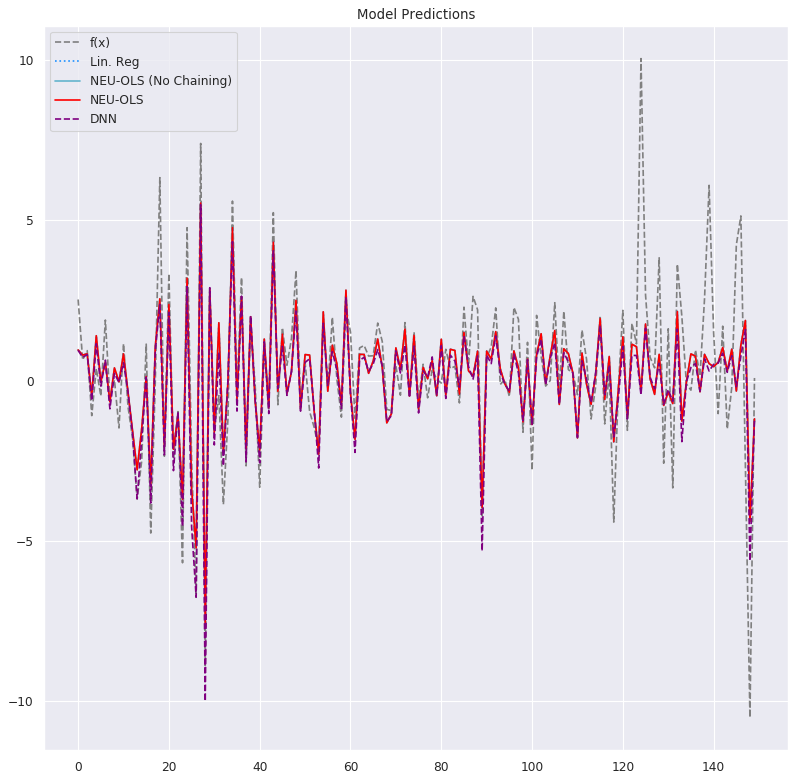

In [12]:
if Option_Function != 'SnP':
    # Initialize Plot #
    #-----------------#
    fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

    # Generate Plots #
    #----------------#

    # Plot Signal
    plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
    # Plot Data
    plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
    plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

    #----------#
    # Model(s) #
    #----------#
    # Ordinary Linear Regression (OLS)
    plt.plot(np.array(data_x_test_raw).reshape(-1,),ENET_OLS_y_hat_test, color = 'dodgerblue',linestyle=":", label='Lin. Reg')

    # Plot NEU-OLS
    plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_OLS_test_nochain, color = 'c',label='NEU-OLS (No Chaining)')
    plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_OLS_y_hat_test_FC, color = 'red',label='NEU-OLS')
    plt.plot(np.array(data_x_test_raw).reshape(-1,),ffNN_y_hat_test, color = 'purple',linestyle="--",  label='DNN')

    # Format Plot #
    #-------------#
    plt.legend(loc="upper left")
    plt.title("Model Predictions")

    # Export #
    #--------#
    # SAVE Figure to .eps
    plt.savefig('./outputs/plotsANDfigures/OLS.pdf', format='pdf')
    # Show Plot
    if is_visuallty_verbose == True:
        plt.show(block=False)
else:
        # Initialize Plot #
    #-----------------#
    fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

    # Generate Plots #
    #----------------#

    # Plot Signal
    plt.plot(data_y_test.to_numpy(),color='gray',label='f(x)',linestyle='--')

    #----------#
    # Model(s) #
    #----------#
#     Ordinary Linear Regression (OLS)
    plt.plot(ENET_OLS_y_hat_test, color = 'dodgerblue',linestyle=":", label='Lin. Reg')

    # Plot NEU-OLS
    plt.plot(NEU_OLS_test_nochain, color = 'c',label='NEU-OLS (No Chaining)')
    plt.plot(NEU_OLS_y_hat_test_FC, color = 'red',label='NEU-OLS')
    plt.plot(ffNN_y_hat_test, color = 'purple',linestyle="--",  label='DNN')

    # Format Plot #
    #-------------#
    plt.legend(loc="upper left")
    plt.title("Model Predictions")

    # Export #
    #--------#
    # SAVE Figure to .eps
    plt.savefig('./outputs/plotsANDfigures/SnP_OLS.pdf', format='pdf')
    # Show Plot
    if is_visuallty_verbose == True:
        plt.show(block=False)

#### Error Distribution NEU-OLS

In [13]:
if Option_Function != 'SnP':
    get_Error_distribution_plots(data_y_test,ENET_OLS_y_hat_test,NEU_OLS_y_hat_test_FC,"OLS")

#### Comparison between Elastic-Net and NEU-ENET

In [14]:
#-----------------#
# Linear Model(s) #
#-----------------#
# NEU-Elastic Net Performance
print("NEU-ENET Performance:")
if Option_Function != 'SnP':
    print(reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test))
else:
    print(reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)))


# Elastic-Net Performance
print("Elastic-Net Performance:")
if Option_Function != 'SnP':
    print(reporter(ENET_OLS_y_hat_train,ENET_OLS_y_hat_test,data_y,data_y_test))
else:
    print(reporter(ENET_OLS_y_hat_train,ENET_OLS_y_hat_test,data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)))


# ffNN
print("Benchmark: DNN (ffNN)")
if Option_Function != 'SnP':
    print(reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test))
else:
    print(reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)))


# NEU-OLS with Coupled
print("Benchmark: NEU-OLS (with Chaining)")
if Option_Function != 'SnP':
    print(reporter(NEU_OLS_y_hat_train_FC,NEU_OLS_y_hat_test_FC,data_y,data_y_test))
else:
    print(reporter(NEU_OLS_y_hat_train_FC.reshape(-1,),NEU_OLS_y_hat_test_FC.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)))


# NEU-OLS No Chaining
print("Benchmark: NEU-OLS (no Chaining)")
if Option_Function != 'SnP':
    print(reporter(NEU_OLS_train_nochain,NEU_OLS_test_nochain,data_y,data_y_test))
else:
    print(reporter(NEU_OLS_train_nochain.reshape(-1,),NEU_OLS_test_nochain.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)))



# Depth Used with Chaining #
print("#======================#")
print("NEU-Chained Feature Depth"+str(NEU_Feature_Depth))
print("Time to Trian NEU-OLS: "+str(end - start))
print("#======================#")

NEU-ENET Performance:
                 Train        Test
Er. 95L  -5.506904e-02   -0.070714
Er. Mean -1.438353e-09    0.177951
Er. 95U   5.467229e-02    0.451197
MAE       4.103598e-01    1.011887
MSE       3.475261e-01    2.660958
MAPE      9.745145e+02  205.312664
Elastic-Net Performance:
                 Train        Test
Er. 95L  -5.396757e-02   -0.074818
Er. Mean  3.956251e-18    0.177952
Er. 95U   5.622981e-02    0.446536
MAE       4.103598e-01    1.011888
MSE       3.475261e-01    2.660962
MAPE      9.732549e+02  205.311950
Benchmark: DNN (ffNN)
               Train        Test
Er. 95L    -0.010661    0.124388
Er. Mean    0.042666    0.370742
Er. 95U     0.096841    0.632854
MAE         0.399444    1.023894
MSE         0.336617    2.670056
MAPE      348.692567  320.202079
Benchmark: NEU-OLS (with Chaining)
                 Train        Test
Er. 95L  -5.453396e-02   -0.073500
Er. Mean -9.413710e-09    0.177952
Er. 95U   5.506871e-02    0.444856
MAE       4.103598e-01    1.011888


---
# Non-Linear Models
---

### NEU-Kernel Ridge Regression *(decoupled implementation)*

In [60]:
# 2) Perform Linear Regression on Feature-Space #
#===============================================#
NEU_KReg_y_hat_train_pre,NEU_KReg_y_hat_test_pre, NEU_KReg_model = get_Kernel_Ridge_Regressor(data_x_in = data_x_featured_train,
                                                                                              data_x_test_in = data_x_featured_test,
                                                                                              data_y_in = data_y)


NEU_KReg_y_hat_train = NEU_KReg_y_hat_train_pre
NEU_KReg_y_hat_test = NEU_KReg_y_hat_test_pre

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Batch computation too fast (0.0405s.) Setting batch_size=2.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=3)]: Batch computation too fast (0.1028s.) Setting batch_size=4.
[Parallel(n_jobs=3)]: Done  18 out of  20 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:    0.3s finished


#### Visual Comaprison between the Kernel Ridge Regression and the NEU-Kernel Ridge Regression models:

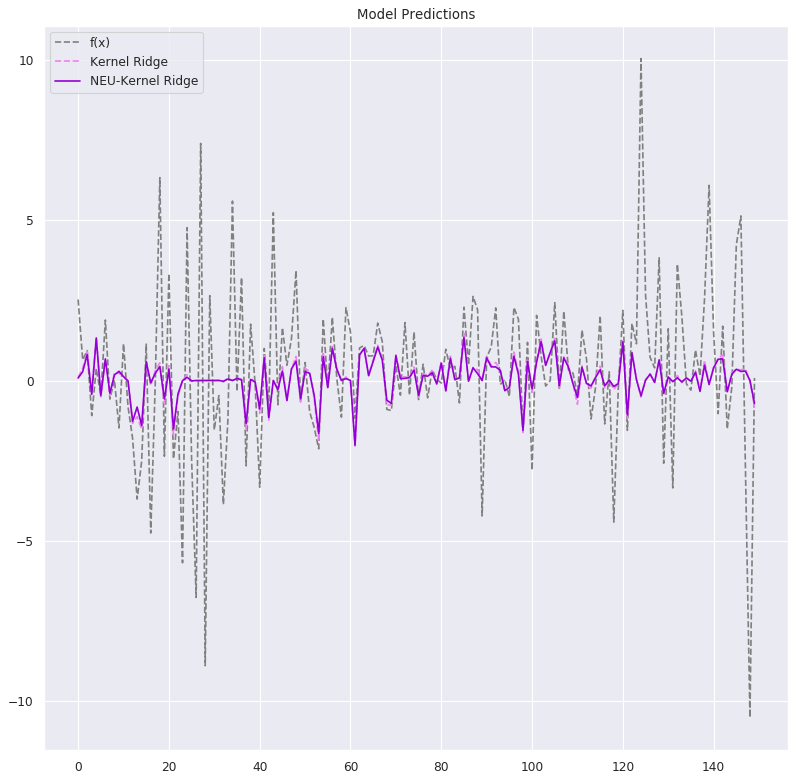

In [61]:
if Option_Function != 'SnP':
    # Initialize Plot #
    #-----------------#
    fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

    # Generate Plots #
    #----------------#

    # Plot Signal
    plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
    # Plot Data
    plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
    plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

    #----------#
    # Model(s) #
    #----------#
    # Kernel Ridge Regressor
    plt.plot(np.array(data_x_test_raw).reshape(-1,),f_hat_kernel_ridge_test,color='violet',linestyle="--",label='Kernel Ridge')
    # NEU-Kernel Ridge Regressor
    plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_KReg_y_hat_test,color='darkviolet',label='NEU-Kernel Ridge')

    # Format Plot #
    #-------------#
    plt.legend(loc="upper left")
    plt.title("Model Predictions")

    # Export #
    #--------#
    # SAVE Figure to .eps
    plt.savefig('./outputs/plotsANDfigures/Kernel_Ridge.pdf', format='pdf')
    # Show Plot
    if is_visuallty_verbose == True:
        plt.show(block=False)
else:
    # Initialize Plot #
    #-----------------#
    fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

    # Generate Plots #
    #----------------#

    # Plot Signal
    plt.plot(data_y_test.to_numpy(),color='gray',label='f(x)',linestyle='--')

    #----------#
    # Model(s) #
    #----------#
    # Kernel Ridge Regressor
    plt.plot(f_hat_kernel_ridge_test,color='violet',linestyle="--",label='Kernel Ridge')
    # NEU-Kernel Ridge Regressor
    plt.plot(NEU_KReg_y_hat_test,color='darkviolet',label='NEU-Kernel Ridge')

    # Format Plot #
    #-------------#
    plt.legend(loc="upper left")
    plt.title("Model Predictions")

    # Export #
    #--------#
    # SAVE Figure to .eps
    plt.savefig('./outputs/plotsANDfigures/Kernel_Ridge.pdf', format='pdf')
    # Show Plot
    if is_visuallty_verbose == True:
        plt.show(block=False)

In [62]:
if Option_Function != 'SnP':
    get_Error_distribution_plots(data_y_test,f_hat_kernel_ridge_test,NEU_KReg_y_hat_test,"Kernel_Ridge")

#### Numerical Comparison between the Kernel Ridge regressor and NEU-Kernel Ridge regressor models:

In [63]:
#-----------------------#
# Kernel Ridge Model(s) #
#-----------------------#
# Kernel Ridge Performance
print("Kernel Ridge-Performance:")
if Option_Function != 'SnP':
    print(reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test))
else:
    print(reporter(f_hat_kernel_ridge_train.reshape(-1,),f_hat_kernel_ridge_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)))


# NEU-Kernel Ridge Performance
print("NEU-Kernel Ridge-Performance:")
if Option_Function != 'SnP':
    print(reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test))
else:
    print(reporter(NEU_KReg_y_hat_train.reshape(-1,),NEU_KReg_y_hat_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)))

Kernel Ridge-Performance:
               Train          Test
Er. 95L    -0.050440 -1.765548e-01
Er. Mean   -0.006527  2.240551e-01
Er. 95U     0.037610  6.214655e-01
MAE         0.340513  1.552723e+00
MSE         0.228238  6.097944e+00
MAPE      306.582147  1.443915e+18
NEU-Kernel Ridge-Performance:
               Train          Test
Er. 95L    -0.049073 -1.754857e-01
Er. Mean   -0.007271  2.290409e-01
Er. 95U     0.035954  6.203998e-01
MAE         0.329575  1.583130e+00
MSE         0.212382  6.201726e+00
MAPE      233.087214  3.603762e+22


## Tree Model(s):
*Naturally, all of these have a decoupled implementation*.

In [19]:
# 2) Perform Linear Regression on Feature-Space #
#===============================================#
NEU_GBRF_y_hat_train_pre,NEU_GBRF_y_hat_test_pre, GBRF_w_NEU_features = get_GBRF(X_train = data_x_featured_train,
                                                                                 X_test = data_x_featured_test,
                                                                                 y_train = data_y)

NEU_GBRF_y_hat_train = NEU_GBRF_y_hat_train_pre
NEU_GBRF_y_hat_test = NEU_GBRF_y_hat_test_pre

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   11.0s finished


#### Visual Comaprison between the GBRF and the NEU-GBRF models:

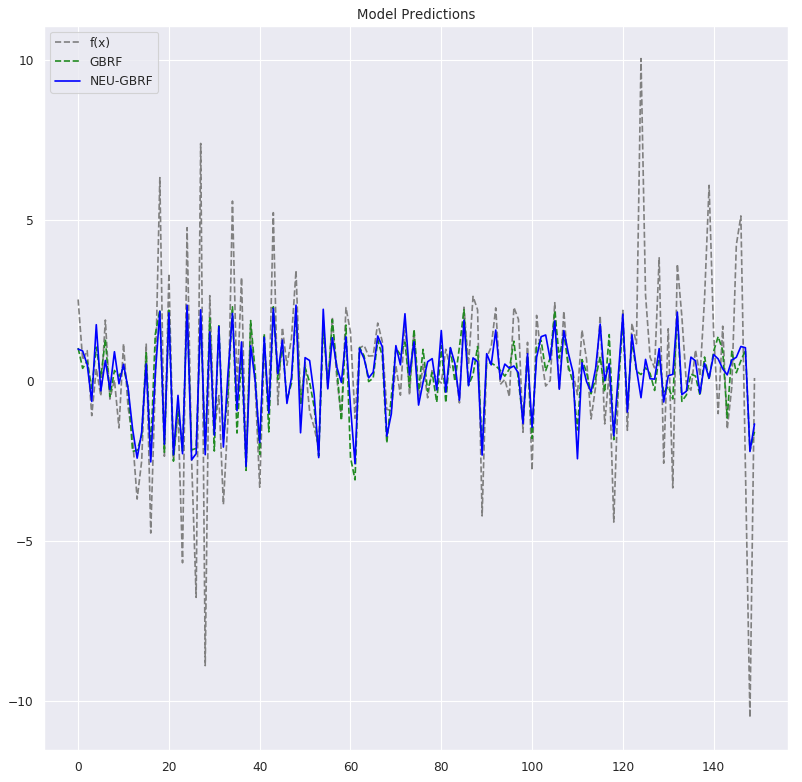

In [20]:
if Option_Function != 'SnP':
    # Initialize Plot #
    #-----------------#
    plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

    # Generate Plots #
    #----------------#

    # Plot Signal
    plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
    # Plot Data
    plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
    plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

    #----------#
    # Model(s) #
    #----------#
    # Plot Gradient-Boosted Random Forest Regressor (GBRF):
    plt.plot(np.array(data_x_test_raw).reshape(-1,),GBRF_y_hat_test, linestyle="--", color = 'forestgreen', label='GBRF')
    # Plot NEU-GBRF:
    plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_GBRF_y_hat_test, color = 'blue',label='NEU-GBRF')


    # Format Plot #
    #-------------#
    plt.legend(loc="upper left")
    plt.title("Model Predictions")


    # Export #
    #--------#
    # SAVE Figure to .eps
    plt.savefig('./outputs/plotsANDfigures/GBRF.pdf', format='pdf')
    # Show Plot
    if is_visuallty_verbose == True:
        plt.show(block=False)
else:
        # Initialize Plot #
    #-----------------#
    plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

    # Generate Plots #
    #----------------#

    # Plot Signal
    plt.plot(data_y_test.to_numpy(),color='gray',label='f(x)',linestyle='--')

    #----------#
    # Model(s) #
    #----------#
    # Plot Gradient-Boosted Random Forest Regressor (GBRF):
    plt.plot(GBRF_y_hat_test, linestyle="--", color = 'forestgreen', label='GBRF')
    # Plot NEU-GBRF:
    plt.plot(NEU_GBRF_y_hat_test, color = 'blue',label='NEU-GBRF')


    # Format Plot #
    #-------------#
    plt.legend(loc="upper left")
    plt.title("Model Predictions")


    # Export #
    #--------#
    # SAVE Figure to .eps
    plt.savefig('./outputs/plotsANDfigures/GBRF.pdf', format='pdf')
    # Show Plot
    if is_visuallty_verbose == True:
        plt.show(block=False)

In [21]:
if Option_Function != 'SnP':
    get_Error_distribution_plots(data_y_test,GBRF_y_hat_test,NEU_GBRF_y_hat_test,"GBRF")

#### Numerical Comparison between the GBRF and NEU-GBRF models:

In [22]:
#---------------#
# Tree Model(s) #
#---------------#
# GBRF Performance
print("GBRF-Performance:")
if Option_Function != 'SnP':
    print(reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test))
else:
    print(reporter(GBRF_y_hat_train.reshape(-1,),GBRF_y_hat_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)))

# NEU-GBRF Performance
print("NEU-GBRF-Performance:")
if Option_Function != 'SnP':
    print(reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test))
else:
    print(reporter(NEU_GBRF_y_hat_train.reshape(-1,),NEU_GBRF_y_hat_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)))

GBRF-Performance:
                 Train        Test
Er. 95L  -5.759256e-03   -0.102111
Er. Mean -1.508321e-17    0.206533
Er. 95U   5.448153e-03    0.531450
MAE       3.164023e-02    1.259415
MSE       3.664748e-03    3.894041
MAPE      2.130660e+01  542.205278
NEU-GBRF-Performance:
                 Train        Test
Er. 95L  -3.293091e-03   -0.166288
Er. Mean  1.335235e-17    0.143092
Er. 95U   3.331335e-03    0.458474
MAE       1.367680e-02    1.250362
MSE       1.233878e-03    3.830042
MAPE      5.974068e+00  522.111840


---
## Neural Networks: 
---
### NEU-ffNN

#### A) Fully-Coupled Implementation
- Train feature-map + ffNN ($\hat{f}\circ \phi$) in one go.

In [23]:
# tf.random.set_seed(2020)
# NEU_ffNN_y_hat_train, NEU_ffNN_y_hat_test = build_NEU_ffNN_w_feature_only(n_folds = CV_folds, 
#                                                                           n_jobs = n_jobs, 
#                                                                           n_iter = n_iter, 
#                                                                           param_grid_in = param_grid_NEU_Nets, 
#                                                                           X_train = data_x, 
#                                                                           y_train = data_y,
#                                                                           X_test = data_x_test)

#### B) Decoupled NEU-ffNN

In [24]:
tf.random.set_seed(2020)
NEU_ffNN_y_hat_train, NEU_ffNN_y_hat_test = build_ffNN(n_folds = CV_folds, 
                                                       n_jobs = n_jobs, 
                                                       n_iter = n_iter, 
                                                       param_grid_in = param_grid_Vanilla_Nets, 
                                                       X_train = data_x_featured_train, 
                                                       y_train = data_y,
                                                       X_test = data_x_featured_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    5.0s finished


Epoch 1/50
15/15 [==============================] - 0s 3ms/step - loss: 0.5689 - mse: 0.6350 - mae: 0.5689 - mape: 127.3633
Epoch 2/50
15/15 [==============================] - 0s 4ms/step - loss: 0.4228 - mse: 0.3638 - mae: 0.4228 - mape: 302.2723
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.4211 - mse: 0.3720 - mae: 0.4211 - mape: 217.0965
Epoch 4/50
15/15 [==============================] - 0s 4ms/step - loss: 0.4146 - mse: 0.3564 - mae: 0.4146 - mape: 265.5504
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.4114 - mse: 0.3536 - mae: 0.4114 - mape: 263.1819
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.4127 - mse: 0.3583 - mae: 0.4127 - mape: 258.1617
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 0.4153 - mse: 0.3621 - mae: 0.4153 - mape: 280.6625
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.4095 - mse: 0.3527 - mae: 0.4095 - mape: 248.4348
Epoch 9/

---

**Note:** The following two models are purely out of personal curiosity and are not included in the paper.  Feel free to use them, they perform well. 

---

## Visualization

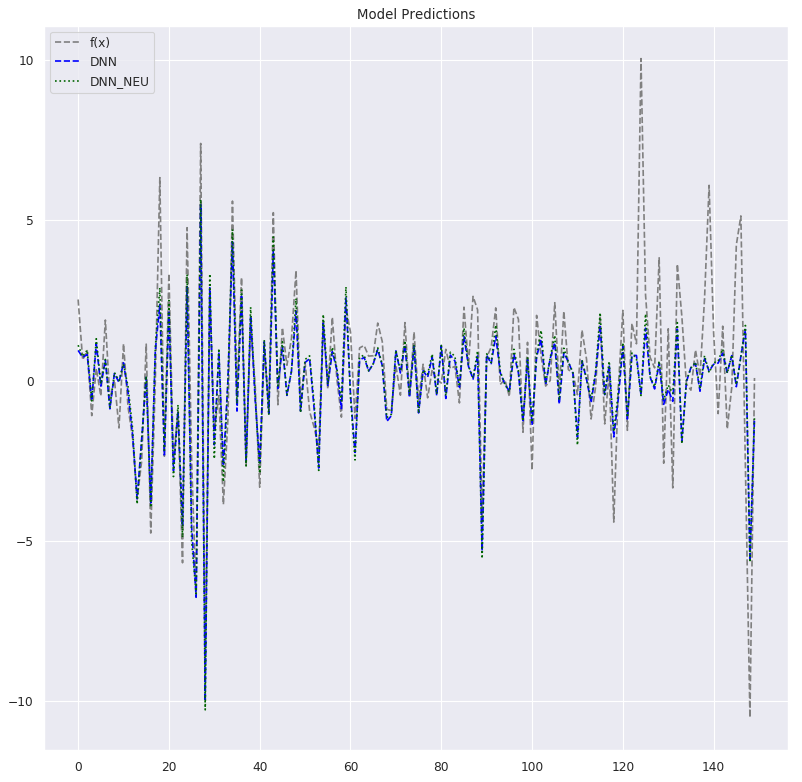

In [25]:
if Option_Function != 'SnP':
    # Initialize Plot #
    #-----------------#
    plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

    # Generate Plots #
    #----------------#

    # Plot Signal
    plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
    # Plot Data
    plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
    plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

    #--------------------#
    # Benchmark Model(s) #
    #--------------------#
    # Plot ffNN
    plt.plot(np.array(data_x_test_raw).reshape(-1,),ffNN_y_hat_test, color = 'blue',linestyle="--",  label='DNN')


    #--------------#
    # NEU-Model(s) #
    #--------------#
    # Plot NEU-ffNN (Training Variants)
    plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_ffNN_y_hat_test, linestyle=":", color = 'darkgreen',label='DNN_NEU_coupled')



    # Format Plot #
    #-------------#
    plt.legend(loc="upper left")
    plt.title("Model Predictions")

    # Export #
    #--------#
    # SAVE Figure to .eps
    plt.savefig('./outputs/plotsANDfigures/Neural_Network_Models.pdf', format='pdf')
    # Show Plot
    if is_visuallty_verbose == True:
        plt.show(block=False)
else:
        # Initialize Plot #
    #-----------------#
    plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

    # Generate Plots #
    #----------------#

    # Plot Signal
    plt.plot(data_y_test.to_numpy(),color='gray',label='f(x)',linestyle='--')
   
    #--------------------#
    # Benchmark Model(s) #
    #--------------------#
    # Plot ffNN
    plt.plot(ffNN_y_hat_test, color = 'blue',linestyle="--",  label='DNN')


    #--------------#
    # NEU-Model(s) #
    #--------------#
    # Plot NEU-ffNN (Training Variants)
    plt.plot(NEU_ffNN_y_hat_test, linestyle=":", color = 'darkgreen',label='DNN_NEU')



    # Format Plot #
    #-------------#
    plt.legend(loc="upper left")
    plt.title("Model Predictions")

    # Export #
    #--------#
    # SAVE Figure to .eps
    plt.savefig('./outputs/plotsANDfigures/Neural_Network_Models.pdf', format='pdf')
    # Show Plot
    if is_visuallty_verbose == True:
        plt.show(block=False)

In [26]:
if Option_Function != 'SnP':
    get_Error_distribution_plots(data_y_test,ffNN_y_hat_test,NEU_ffNN_y_hat_test,"ffNN")

---
---
---

---
# Result(s)
---

## Generate Results Table(s):

In [64]:
if Option_Function != 'SnP':
    #=========#
    # Testing #
    #=========#
    test_performance  = pd.DataFrame({"Smoothin Splines": reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test).iloc[:,0],
                                       "LOESS": reporter(LOESS_prediction_train,LOESS_prediction_test,data_y,data_y_test).iloc[:,0],
                                       "Elastic Net": reporter(ENET_OLS_y_hat_train,ENET_OLS_y_hat_test,data_y,data_y_test).iloc[:,0],
                                       "NEU-OLS": reporter(NEU_OLS_y_hat_train_FC,NEU_OLS_y_hat_test_FC,data_y,data_y_test).iloc[:,0],
                                       "NEU-OLS (no chain)": reporter(NEU_OLS_train_nochain,NEU_OLS_test_nochain,data_y,data_y_test).iloc[:,0],
                                       "NEU-ENET": reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test).iloc[:,0],
                                       "Kernel": reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test).iloc[:,0],
                                       "NEU-KerRidge": reporter(NEU_KReg_y_hat_train,NEU_KReg_y_hat_test,data_y,data_y_test).iloc[:,0],
                                       "GBRF": reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test).iloc[:,0],
                                       "NEU-GBRF": reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test).iloc[:,0],
                                       "ffNN": reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test).iloc[:,0],
                                       "NEU-ffNN": reporter(NEU_ffNN_y_hat_train,NEU_ffNN_y_hat_test,data_y,data_y_test).iloc[:,0]}).transpose()


    test_performance.to_latex("./outputs/tables/Test_performance.tex")

    #==========#
    # Training #
    #==========#
    train__performance  = pd.DataFrame({"Smoothin Splines": reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test).iloc[:,1],
                                       "LOESS": reporter(LOESS_prediction_train,LOESS_prediction_test,data_y,data_y_test).iloc[:,1],
                                       "Elastic Net": reporter(ENET_OLS_y_hat_train,ENET_OLS_y_hat_test,data_y,data_y_test).iloc[:,1],
                                       "NEU-OLS": reporter(NEU_OLS_y_hat_train_FC,NEU_OLS_y_hat_test_FC,data_y,data_y_test).iloc[:,1],
                                        "NEU-OLS (no chain)": reporter(NEU_OLS_train_nochain,NEU_OLS_test_nochain,data_y,data_y_test).iloc[:,1],
                                       "NEU-ENET": reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test).iloc[:,1],
                                       "Kernel": reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test).iloc[:,1],
                                       "NEU-KerRidge": reporter(NEU_KReg_y_hat_train,NEU_KReg_y_hat_test,data_y,data_y_test).iloc[:,1],
                                       "GBRF": reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test).iloc[:,1],
                                       "NEU-GBRF": reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test).iloc[:,1],
                                       "ffNN": reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test).iloc[:,1],
                                       "NEU-ffNN": reporter(NEU_ffNN_y_hat_train,NEU_ffNN_y_hat_test,data_y,data_y_test).iloc[:,1]}).transpose()

    train__performance.to_latex("./outputs/tables/Train_performance.tex")
    
else:
    
    #=========#
    # Testing #
    #=========#
    test_performance  = pd.DataFrame({"Elastic Net": reporter(ENET_OLS_y_hat_train.reshape(-1,),ENET_OLS_y_hat_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,0],
                                       "NEU-OLS": reporter(NEU_OLS_y_hat_train_FC.reshape(-1,),NEU_OLS_y_hat_test_FC.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,0],
                                       "NEU-OLS (no chain)": reporter(NEU_OLS_train_nochain.reshape(-1,),NEU_OLS_test_nochain.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,0],
                                       "NEU-ENET": reporter(NEU_OLS_y_hat_train.reshape(-1,),NEU_OLS_y_hat_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,0],
                                       "Kernel": reporter(f_hat_kernel_ridge_train.reshape(-1,),f_hat_kernel_ridge_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,0],
                                       "NEU-KerRidge": reporter(NEU_KReg_y_hat_train.reshape(-1,),NEU_KReg_y_hat_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,0],
                                       "GBRF": reporter(GBRF_y_hat_train.reshape(-1,),GBRF_y_hat_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,0],
                                       "NEU-GBRF": reporter(NEU_GBRF_y_hat_train.reshape(-1,),NEU_GBRF_y_hat_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,0],
                                       "ffNN": reporter(ffNN_y_hat_train.reshape(-1,),ffNN_y_hat_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,0],
                                       "NEU-ffNN": reporter(NEU_ffNN_y_hat_train.reshape(-1,),NEU_ffNN_y_hat_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,0],}).transpose()


    test_performance.to_latex("./outputs/tables/Test_performance_SnP.tex")
    test_performance.to_latex("./outputs/tables/Test_performance_SnP_3_sig_fig.tex",float_format="{:0.4f}".format)

    #==========#
    # Training #
    #==========#
    train__performance  = pd.DataFrame({"Elastic Net": reporter(ENET_OLS_y_hat_train.reshape(-1,),ENET_OLS_y_hat_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,1],
                                       "NEU-OLS": reporter(NEU_OLS_y_hat_train_FC.reshape(-1,),NEU_OLS_y_hat_test_FC.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,1],
                                       "NEU-OLS (no chain)": reporter(NEU_OLS_train_nochain.reshape(-1,),NEU_OLS_test_nochain.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,1],
                                       "NEU-ENET": reporter(NEU_OLS_y_hat_train.reshape(-1,),NEU_OLS_y_hat_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,1],
                                       "Kernel": reporter(f_hat_kernel_ridge_train.reshape(-1,),f_hat_kernel_ridge_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,1],
                                       "NEU-KerRidge": reporter(NEU_KReg_y_hat_train.reshape(-1,),NEU_KReg_y_hat_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,1],
                                       "GBRF": reporter(GBRF_y_hat_train.reshape(-1,),GBRF_y_hat_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,1],
                                       "NEU-GBRF": reporter(NEU_GBRF_y_hat_train.reshape(-1,),NEU_GBRF_y_hat_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,1],
                                       "ffNN": reporter(ffNN_y_hat_train.reshape(-1,),ffNN_y_hat_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,1],
                                       "NEU-ffNN": reporter(NEU_ffNN_y_hat_train.reshape(-1,),NEU_ffNN_y_hat_test.reshape(-1,),data_y.to_numpy().reshape(-1,),data_y_test.to_numpy().reshape(-1,)).iloc[:,1],}).transpose()
    
    train__performance.to_latex("./outputs/tables/Train_performance_SnP.tex")
    train__performance.to_latex("./outputs/tables/Train_performance_SnP_3_sig_fig.tex",float_format="{:0.4f}".format)

# Visualize Predictions

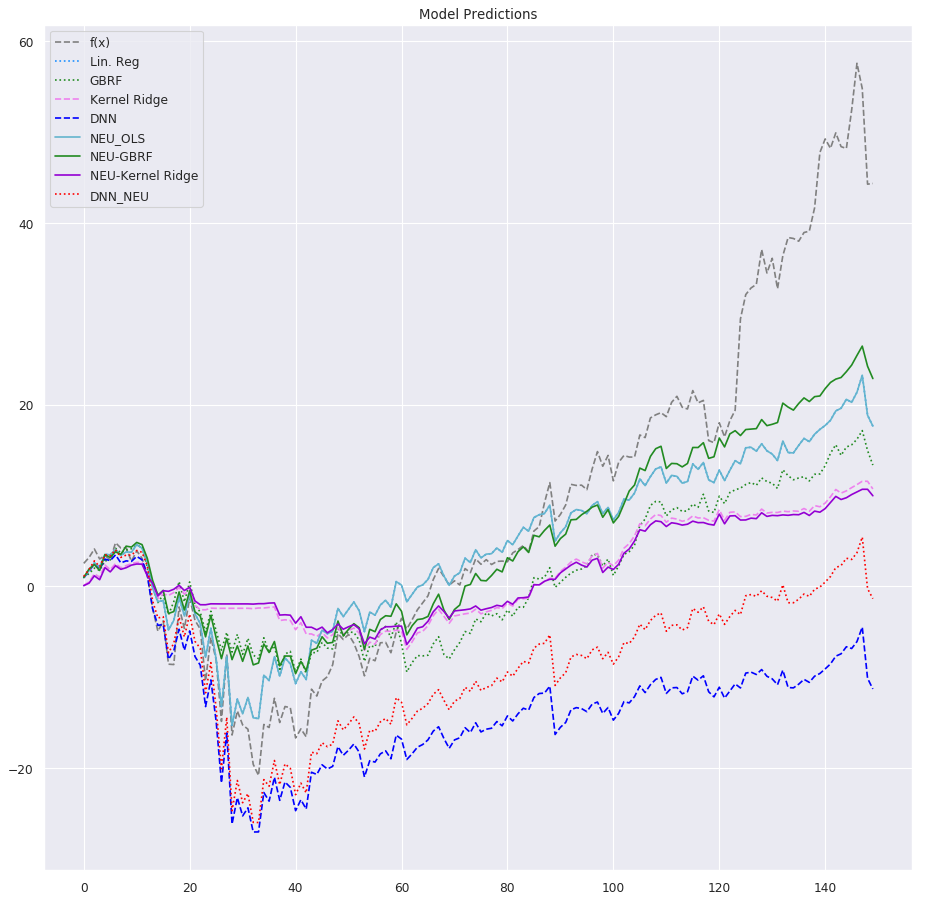

In [65]:
if Option_Function != 'SnP':
    # Initialize Plot #
    #-----------------#
    plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')

    # Generate Plots #
    #----------------#

    # Plot Signal
    plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
    # Plot Data
    plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
    plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

    #--------------------#
    # Benchmark Model(s) #
    #--------------------#
    # Ordinary Linear Regression (OLS)
    plt.plot(np.array(data_x_test_raw).reshape(-1,),ENET_OLS_y_hat_test, color = 'dodgerblue',linestyle=":", label='Lin. Reg')
    # Plot Gradient-Boosted Random Forest Regressor (GBRF):
    plt.plot(np.array(data_x_test_raw).reshape(-1,),GBRF_y_hat_test, color = 'forestgreen',linestyle=":", label='GBRF')
    # Plot Non-Linar Benchmark(s): Classical
    plt.plot(np.array(data_x_test_raw).reshape(-1,),f_hat_smoothing_splines_test,color='grey',linestyle="--",label='Splines')
    plt.plot(np.array(data_x_test_raw).reshape(-1,),LOESS_prediction_test,color='purple',linestyle="--",label='LOESS')
    # Kernel Ridge Regressor
    plt.plot(np.array(data_x_test_raw).reshape(-1,),f_hat_kernel_ridge_test,color='violet',linestyle="--",label='Kernel Ridge')
    # Plot ffNN
    plt.plot(np.array(data_x_test_raw).reshape(-1,),ffNN_y_hat_test, color = 'blue',linestyle="--",  label='DNN')


    #--------------#
    # NEU-Model(s) #
    #--------------#
    # Plot NEU-OLS
    plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_OLS_y_hat_test_FC, color = 'c',label='NEU_OLS')
    # Plot NEU-GBRF:
    plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_GBRF_y_hat_test, color = 'forestgreen',label='NEU-GBRF')
    # NEU-Kernel Ridge Regressor
    plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_KReg_y_hat_test,color='darkviolet',label='NEU-Kernel Ridge')
    # Plot NEU-ffNN (Training Variants)
    plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_ffNN_y_hat_test, linestyle=":", color = 'red',label='DNN_NEU')


    # Format Plot #
    #-------------#
    plt.legend(loc="upper left")
    plt.title("Model Predictions")

    # Export #
    #--------#
    # SAVE Figure to .eps
    plt.savefig('./outputs/plotsANDfigures/Full_Picture.pdf', format='pdf')
    # Show Plot
    if is_visuallty_verbose == True:
        plt.show(block=False)
else:
        # Initialize Plot #
    #-----------------#
    plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')

    # Generate Plots #
    #----------------#

    # Plot Signal
    plt.plot(np.cumsum(data_y_test.to_numpy()),color='gray',label='f(x)',linestyle='--')

    #--------------------#
    # Benchmark Model(s) #
    #--------------------#
    # Ordinary Linear Regression (OLS)
    plt.plot(np.cumsum(ENET_OLS_y_hat_test), color = 'dodgerblue',linestyle=":", label='Lin. Reg')
    # Plot Gradient-Boosted Random Forest Regressor (GBRF):
    plt.plot(np.cumsum(GBRF_y_hat_test), color = 'forestgreen',linestyle=":", label='GBRF')
    # Kernel Ridge Regressor
    plt.plot(np.cumsum(f_hat_kernel_ridge_test),color='violet',linestyle="--",label='Kernel Ridge')
    # Plot ffNN
    plt.plot(np.cumsum(ffNN_y_hat_test), color = 'blue',linestyle="--",  label='DNN')


    #--------------#
    # NEU-Model(s) #
    #--------------#
    # Plot NEU-OLS
    plt.plot(np.cumsum(NEU_OLS_y_hat_test_FC), color = 'c',label='NEU_OLS')
    # Plot NEU-GBRF:
    plt.plot(np.cumsum(NEU_GBRF_y_hat_test), color = 'forestgreen',label='NEU-GBRF')
    # NEU-Kernel Ridge Regressor
    plt.plot(np.cumsum(NEU_KReg_y_hat_test),color='darkviolet',label='NEU-Kernel Ridge')
    # Plot NEU-ffNN (Training Variants)
    plt.plot(np.cumsum(NEU_ffNN_y_hat_test), linestyle=":", color = 'red',label='DNN_NEU')


    # Format Plot #
    #-------------#
    plt.legend(loc="upper left")
    plt.title("Model Predictions")

    # Export #
    #--------#
    # SAVE Figure to .eps
    plt.savefig('./outputs/plotsANDfigures/Full_Picture_SnP_Trackers_Testset.pdf', format='pdf')
    # Show Plot
    if is_visuallty_verbose == True:
        plt.show(block=False)

 ---

## Performance Report
- First, we print the comparison tables (so it can be viewed from the command-line if it is being run live on a grid/cluster/remotely).
- Second, we display the training and testing performances in clean dataframes.

In [66]:
#--------------------#
# Classical Model(s) #
#--------------------#
if Option_Function != 'SnP':
    print("NEU-ENET Performance:")
    # OLS Performance
    print("OLS-Performance:")
#     print(reporter(OLS_y_hat_train,OLS_y_hat_test,data_y,data_y_test))

    # NEU-OLS Performance
    print("NEU-OLS-Performance:")
    print(reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test))

In [67]:
#-----------------------#
# Kernel Ridge Model(s) #
#-----------------------#
if Option_Function != 'SnP':
    # Kernel Ridge Performance
    print("Kernel Ridge-Performance:")
    print(reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test))

    # NEU-Kernel Ridge Performance
    print("NEU-Kernel Ridge-Performance:")
    print(reporter(NEU_KReg_y_hat_train,NEU_KReg_y_hat_test,data_y,data_y_test))

In [68]:
#---------------#
# Tree Model(s) #
#---------------#
if Option_Function != 'SnP':
    # GBRF Performance
    print("GBRF-Performance:")
    print(reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test))

    # NEU-GBRF Performance
    print("NEU-GBRF-Performance:")
    print(reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test))

In [69]:
#-----------------------------------------------------#
# Classical Non-Linear Univariate Regression Model(s) #
#-----------------------------------------------------#
if Option_Function != 'SnP':
    # Splines Performance
    print("Splines-Performance:")
    print(reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test))

    # Loess Performance
    print("LOESS Performance:")
    print(reporter(LOESS_prediction_train,LOESS_prediction_test,data_y,data_y_test))

In [70]:
#--------------#
# DNN Model(s) #
#--------------#
if Option_Function != 'SnP':
    # ffNN Performance
    print("ffNN-Performance:")
    print(reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test))

    # NEU-ffNN Performance
    print("NEU-ffNN (Coupled) Performance:") #Readout Form!
    print(reporter(NEU_ffNN_y_hat_train,NEU_ffNN_y_hat_test,data_y,data_y_test))

    # print("NEU-ffNN (Decoupled) Performance:")
    # print(reporter(NEU_ffNN_y_hat_train_Dcpld,NEU_ffNN_y_hat_test_Dcpld,data_y,data_y_test))

# Report

## Re-Summarize Learning Problem for easy recap :)

In [71]:
if Option_Function != 'SnP':
    print("Simulation Confiugration Information:")
    print(" ")
    print("=========================================================================================================================================================")
    print(the_facts)
    print("=========================================================================================================================================================")
    print(" ")

## Train-Set Performance

In [72]:
train__performance.round(5)

,Er. 95L,Er. Mean,Er. 95U,MAE,MSE,MAPE
Elastic Net,-0.07418,0.17795,0.44345,1.01189,2.66096,2.053119e+02
NEU-OLS,-0.08054,0.17795,0.44565,1.01189,2.66096,2.053106e+02
NEU-OLS (no chain),-0.07543,0.17795,0.44547,1.01189,2.66096,2.053106e+02
NEU-ENET,-0.07084,0.17795,0.44371,1.01189,2.66096,2.053127e+02
Kernel,-0.16786,0.22406,0.61973,1.55272,6.09794,1.443915e+18
NEU-KerRidge,-0.18490,0.22904,0.62255,1.58313,6.20173,3.603762e+22
GBRF,-0.10780,0.20653,0.52355,1.25941,3.89404,5.422053e+02
NEU-GBRF,-0.16959,0.14309,0.45880,1.25036,3.83004,5.221118e+02
ffNN,0.12910,0.37074,0.62935,1.02389,2.67006,3.202021e+02
NEU-ffNN,0.05908,0.30450,0.57957,1.01074,2.63040,4.995392e+02


## Test-Set Performance

In [73]:
test_performance.round(5)

,Er. 95L,Er. Mean,Er. 95U,MAE,MSE,MAPE
Elastic Net,-0.05427,0.00000,0.05526,0.41036,0.34753,973.25489
NEU-OLS,-0.05414,-0.00000,0.05515,0.41036,0.34753,974.66992
NEU-OLS (no chain),-0.05474,-0.00000,0.05409,0.41036,0.34753,974.66992
NEU-ENET,-0.05332,-0.00000,0.05356,0.41036,0.34753,974.51450
Kernel,-0.05100,-0.00653,0.03708,0.34051,0.22824,306.58215
NEU-KerRidge,-0.05079,-0.00727,0.03630,0.32957,0.21238,233.08721
GBRF,-0.00574,-0.00000,0.00553,0.03164,0.00366,21.30660
NEU-GBRF,-0.00326,0.00000,0.00324,0.01368,0.00123,5.97407
ffNN,-0.01069,0.04267,0.09635,0.39944,0.33662,348.69257
NEU-ffNN,-0.05284,-0.00015,0.05228,0.39250,0.32394,395.95180


## About the NEU-Feature Map

In [74]:
NEU_Feature_Map_w_Chaining

,0
robustness_parameter,0.000
output_dim,1.000
learning_rate,0.001
input_dim,11.000
implicit_dimension,50.000
homotopy_parameter,0.000
feature_map_height,5.000
feature_map_depth,3.000
epochs,50.000
batch_size,32.000


#### The END

---